In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
import sklearn.metrics as metrics
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image  
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from math import *
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import warnings
warnings.filterwarnings("ignore")

D:\Anaconda\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Question.1.

In [2]:
dataOrig=pd.read_csv('C:/Users/jaber/Downloads/GSE17924_series_matrix.txt', sep='\t',skiprows=21, index_col=0)
phenotype=pd.read_csv('C:/Users/jaber/Downloads/GSE17924_series_matrix.txt', sep='\t', index_col=0)
phenotype=phenotype.iloc[2].to_frame()
phenotype=phenotype.replace('severity: DF',0)
phenotype=phenotype.replace('severity: DHF',2)
phenotype=phenotype.replace('severity: DSS',1)
phenotype1=phenotype[phenotype.severity != 2]
phenotype2=phenotype[phenotype.severity == 2]
data=dataOrig[phenotype1.index]

Question.2.

In [3]:
data_transp=data.transpose()

In [4]:
mean=data_transp.mean()

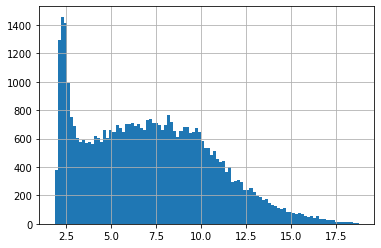

In [5]:
mean.hist(bins=100)

In [6]:
var=data_transp.var()

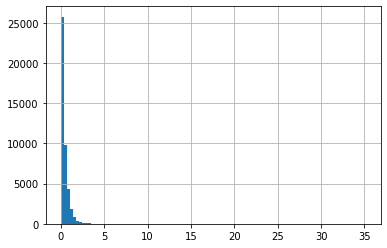

In [7]:
var.hist(bins=100)

In [8]:
Orig=data.copy()

In [9]:
Orig['Mean']=mean

In [10]:
Orig['Variance']=var

In [11]:
data2=Orig[Orig["Mean"]>3]
data3=data2[data2["Variance"]>2]
data3 = data3.drop(columns = ['Mean', 'Variance'])

In [12]:
X=data3.transpose().values

In [13]:
feature_cols=data3.columns

In [14]:
y=phenotype1.values
n_classes = y.shape[1]

In [15]:
loo = LeaveOneOut()
loo.get_n_splits(X)

35

Question 3.
Question 4.a.

In [16]:
def ConfIntervAUC(auc,z_halfAlpha,dfphenotypes):
    ncases=dfphenotypes.sum()
    ncontrols=len(dfphenotypes)-ncases
    z=z_halfAlpha
    qcontrols=auc/(2-auc)
    qcases=2*pow(auc,2)/(1+auc)
    SE_auc=sqrt((auc*(1-auc)+(ncontrols-1)*(qcontrols-pow(auc,2))+(ncases-1)*(qcases-pow(auc,2))))/(ncases*ncontrols)
    CI_auc=z*SE_auc
    return CI_auc

In [17]:
def train (clf):
    proba=[]
    preds=[]
    acc=0
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = clf.fit(X_train,y_train.ravel())
        proba.append(clf.predict_proba(X_test)[0][1])
        preds.append(clf.predict(X_test))
        y_pred = clf.predict(X_test)
        acc+=metrics.accuracy_score(y_test, y_pred.ravel())/len(X)
    fpr, tpr, threshold = metrics.roc_curve(y, proba)
    roc_auc = metrics.auc(fpr, tpr)
    CI_auc = ConfIntervAUC(roc_auc, 1.96,pd.DataFrame(preds))
    print(CI_auc)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return acc

0    0.007348
dtype: float64


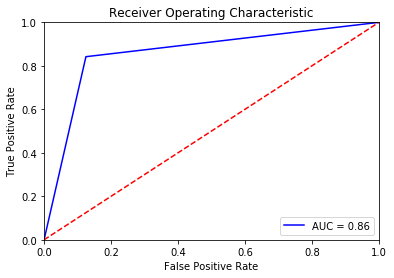

0.8571428571428573


In [18]:
clf = DecisionTreeClassifier()
acc=train(clf)
print(acc)

0    0.005316
dtype: float64


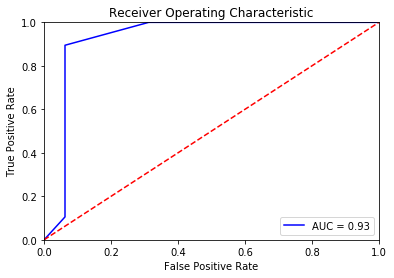

0.9142857142857145


In [19]:
clf = BaggingClassifier()
acc=train(clf)
print(acc)

0    0.005578
dtype: float64


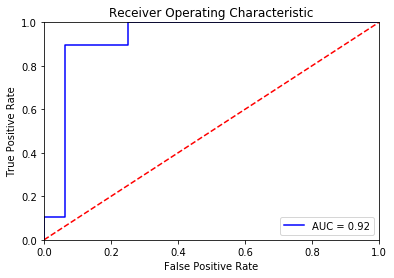

0.8857142857142859


In [20]:
clf = GradientBoostingClassifier()
acc=train(clf)
print(acc)

0    0.004813
dtype: float64


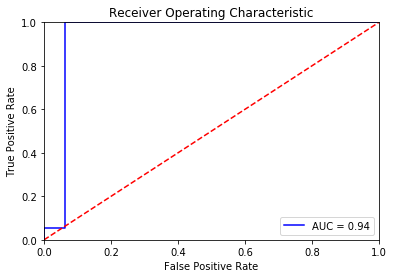

0.9142857142857145


In [21]:
Blf = RandomForestClassifier()
clf = AdaBoostClassifier(base_estimator=Blf)
acc=train(clf)
print(acc)

0    0.005808
dtype: float64


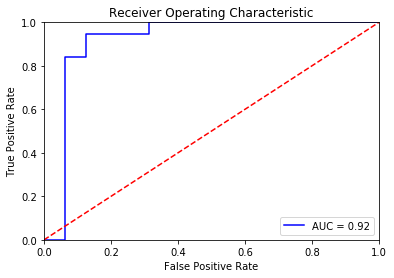

0.8857142857142859


In [22]:
clf = svm.SVC(probability=True,kernel="linear")
acc=train(clf)
print(acc)

0    0.015582
dtype: float64


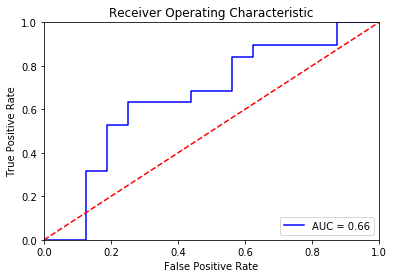

0.6571428571428573


In [23]:
clf = svm.SVC(probability=True,kernel="rbf")
acc=train(clf)
print(acc)

0    0.01509
dtype: float64


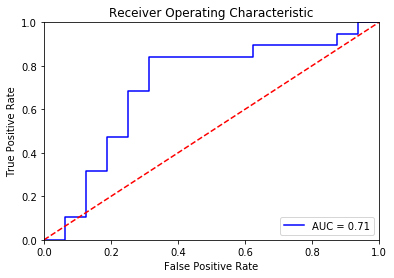

0.6571428571428573


In [24]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
acc=train(clf)
print(acc)

0    0.005694
dtype: float64


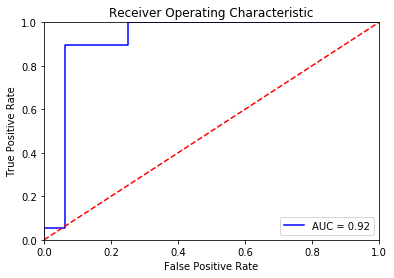

0.8857142857142859


In [25]:
clf= LogisticRegression()
acc=train(clf)
print(acc)

Question 4.b.

 - En terme d'auc, la méthode la plus performante est la méthode de classification utilisant Adaboost. 

Question 4.c.


- L'intervalle d'incertitude tient compte de la taille du jeu de données, la somme de ses éléments et l'AUC utilisée. Par contre, il ne prend pas en compte l'entraînement de la méthode qui est nécessaire pour la méthode utilisée.

Question 5.

 - En terme de performance prédictive, avec la métrique utilisée ( ici, la précision ), deux classifieurs sont en tête et ex-aequo, le classifieur utilisant le bagging et le classifieur utilisant Adaboost. Les moins performants sont les classifieurs KNN et SVM avec un kernel gaussien.

 - Les classifieurs utilisant les méthodes de Boosting et de Bagging ne permettent malheureusement pas d'identifier les transcrits qui jouent un rôle prépondérant dans la disctinction entre les deux classes. En effet, ces méthodes utilisent un ensemble de classifieurs et elles entraînent de manière parallèle, pour le bagging, ou à la suite, pour le boosting, un ensemble de classifieurs sur les données et les targets et elles sont donc difficilement interprétables mathématiquement car il ne s'agit pas d'un ordre usuel.
 
 - Le modèle le plus facilement interprétable mathématiquement est celui de la régression logistique. En effet, la prédiction consiste à trouver des combinaison linéaire des transcrits ce qui donne une facilité de lecture des résultats. Les transcrits jouant les rôles les plus important ont les coefficients les plus importants associés dans la prédiction, ils sont donc facilement identifiables ( en plus d'être facilement accessible à l'aide de la fonction pré-implémentée coef_ ). On a un précision de près de 89% et une AUC de 0.92, ce qui en fait un classifieur avec des résultats honorables en plus de sa facilité d'inteprétation.
 - La classification utilisant la méthode SVM est de nature géométrique par rapport à la distance à un hyperplan maximisant la distance entre les deux classes à cet hyperplan mais cela reste difficilement inteprétable par la suite pour comprendre quel sont les transcrits qui ont une importance significative. Cela devient encore plus difficile avec l'utilisant d'un noyau, et dans notre cas cela détériore même les résultats en terme de précision et d'AUC.
 - Enfin pour la classification utilisant la méthode RandomForest et Adaboost il s'agit du peaufinage des arbres de décision qui sont déjà difficilement interprétables en temps normal mais il y a une méthode pré-implémentée ( feature_importances_ ) permettant d'observer les transcrits avec un rôle prépondérant.

Question 6.

 - L'algorithme Leave One Out consiste en l'utilisation de toutes les données sauf une pour entraîner notre classifieur puis de valider sur une donnée, en réitérant cette opération sur l'ensemble de notre dataset.

 - Il vaut mieux l'employer sur les petits échantillons plutôt que la k-fold cross validation car il faut profiter au maximum des informations que nous apporte notre dataset qui a sûrement été difficile à produire étant donné sa petite taille. Diviser notre dataset en k sous ensemble et utiliser un sous ensemble entier pour valider reviendrait à diminuer la qualité de notre classifieur puisque nous utilisons forcément moins de données pour l'entraîner.